In [1]:
import numpy as np
import netCDF4 as nc
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import warnings
import multiprocessing
import ctypes as c
from datetime import datetime, time, timedelta
from scipy.interpolate import interp1d
from optparse import OptionParser
from tqdm import tnrange, notebook
from time import sleep
import xarray as xr
from contextlib import contextmanager
from scipy.spatial import cKDTree
from functools import partial
import time
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

def log_interp1d(xx, yy, kind='linear', axis=0):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = interp1d(logx, logy, kind=kind, axis=axis)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def interp_loop(j,w,t,zout,zin,nx):
    w_out = np.full((zout.size,nx),np.nan)
    t_out = np.full((zout.size,nx),np.nan)
    for i in np.arange(nx):
        w_out[:,i] = np.interp(zout,zin[:,j,i],w[:,j,i] )
        t_out[:,i] = np.interp(zout,zin[:,j,i],t[:,j,i] )
        
    return w_out,t_out

@contextmanager
def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()

### OBJECT TRACKING ALGORITHM ###
def storm_track(track_var,analy_vars,vars_4d,thresh,minarea,dx,dt,storm_motion,track_tol):
    track_over_time=False
    ###### UPDRAFT TRACKING ALGORITHM ######
    dims = np.shape(analy_vars)
    nvars = dims[0]
    times = dims[1]
    dim1 = dims[2]
    dim2 = dims[3]

    dims = np.shape(vars_4d)
    nvars4d = dims[0]
    nz = dims[2]

    labels = np.full((times,dim1,dim2),np.nan)
    labels_all = np.full((times,dim1,dim2),np.nan)
    centers = np.full((times,1000,2),np.nan)
    centers_final = np.full((times,1000,2),np.nan)
    label_counts_save = np.full((times,1000),np.nan)
    vars_meso = np.full((nvars,times,1000),np.nan)
    vars_meso_4d = np.full((nvars4d,times,nz,1000),np.nan)
    accum_vars = np.full((nvars,times,1000),np.nan)

    num_previous_tracks = 0
    new_label = 1
    for t in np.arange(times):
        print(t)
        for y in np.arange(dim1):
          for x in np.arange(dim2):
            if (track_var[t,y,x] < thresh): #Go to the next point right if we don't meet the thresh criteria
              #print("Point at %d,%d of %g less than thresh %g"%(y,x,track_var[t,y,x],thresh))
              continue
            elif (y > 0 and  track_var[t,y-1,x] >= thresh): # If B is gt threshold, give this point same label
              labels[t,y,x] = labels[t,y-1,x]
            elif (x+1 < dim2 and y > 0 and track_var[t,y-1,x+1] >= thresh): #If BR is labeled, must check other areas for labels
              c = labels[t,y-1,x+1]
              labels[t,y,x] = c
              if (x > 0 and track_var[t,y-1,x-1] >= thresh): # If point to BL is labeled as well, BL and BR areas connect through this point
                a = labels[t,y-1,x-1]
                if (c != a): #If BL and BR points are different areas, set to same area
                  labels[t,:,:] = np.where(labels[t,:,:] == c, a, labels[t,:,:])
              elif (x > 0 and track_var[t,y,x-1] >= thresh): # If L is labeled but not BL, check to see if L=BR
                d = labels[t,y,x-1]
                if (d != c): #If B = BR, B and BR areas connect through P
                  labels[t,:,:] = np.where(labels[t,:,:] == d, c, labels[t,:,:])
            elif (x > 0 and y > 0 and track_var[t,y-1,x-1] >= thresh): #If BL is labeled but BR and B aren't, P=BL
              labels[t,y,x] = labels[t,y-1,x-1]
            elif (x > 0 and track_var[t,y,x-1] >= thresh): #If L is labeled but BR, B, and BL aren't, P=L
              labels[t,y,x] = labels[t,y,x-1]
            else: #BR, BL, B, and L aren't labeled, we've got a new region Create a new label
              labels[t,y,x] = new_label
              new_label = new_label+1
                

        #Find how many unique region labels we have and return their counts
        labels_cur = labels[t,:,:]
        labels_all[t,:,:] = labels[t,:,:]

        labels_list,label_counts = np.unique(labels_cur[~np.isnan(labels_cur)],return_counts=True)
        if (np.size(labels_list)<1): # If we don't have any regions, go to the next time step
          print("no regions valid, moving to next time step")
          del labels_list
          del labels_cur
          continue

        num_labels = np.size(labels_list)#Count how many unique labels we have
        #label_counts_save[t,0:num_labels] = label_counts

        
        if (np.any(label_counts < minarea)):
          small_areas_labels = labels_list[label_counts < minarea]
          large_areas_labels = labels_list[label_counts >= minarea]
          num_labels = np.size(large_areas_labels)
          print("# large areas = ", num_labels)

          label_counts_save[t,0:num_labels] = np.ndarray.flatten(label_counts[np.argwhere(label_counts >= minarea)])
          #for i in np.arange(np.size(small_areas_labels)):
          #  labels_cur = np.where(labels_cur == small_areas_labels[i],np.nan,labels_cur)
          labels_cur = np.where(np.isin(labels_cur,small_areas_labels),np.nan,labels_cur)
          del small_areas_labels
        else:
          del labels_list
          del label_counts

        labels_list_new = np.unique(labels_cur[~np.isnan(labels_cur)])
        if (np.size(labels_list_new) < 1):
          labels[t,:,:] = labels_cur #2d array with labels at storm locations
          del labels_cur
          del labels_list_new
          continue

        labels[t,:,:] = labels_cur #2d array with labels at storm locations
        del labels_cur
        
        track_var_cur = np.array(track_var)[t,:,:]
        
        for i in np.arange(labels_list_new.size):
          #print("averaging over updraft ", i)
          locs = np.where(labels[t,:,:]==labels_list_new[i])

          centers[t,i,0] = np.ceil(np.sum(locs[0][:]*track_var_cur[locs[0][:],locs[1][:]])/sum(track_var_cur[locs[0][:],locs[1][:]]))
          centers[t,i,1] = np.ceil(np.sum(locs[1][:]*track_var_cur[locs[0][:],locs[1][:]])/sum(track_var_cur[locs[0][:],locs[1][:]]))
        
          vars_meso [:,t,i] = np.nanmean(analy_vars[:,t,locs[0][:],locs[1][:]],axis=(1))
          vars_meso_4d[:,t,:,i] = np.nanmean(vars_4d[:,t,:,locs[0][:],locs[1][:]],axis=(0))
          del locs
        del labels_list_new
        
        
        if (t == 0 or np.all(np.isnan(centers_final[t-1,:,:]))):
          num_new_centers = np.count_nonzero( ~ np.isnan(centers[t,:,0]))
          if (num_new_centers != 0):
            centers_final[t,num_previous_tracks:num_previous_tracks+num_new_centers-1,:] = centers[t,0:num_new_centers-1,:]
            um_previous_tracks = num_previous_tracks + num_new_centers

          continue

        xdist = np.ceil(storm_motion[0]*dt/dx)
        ydist = np.ceil(storm_motion[1]*dt/dx)*-1.0
        centers_pred_y = centers_final[t-1,:,0] + ydist
        centers_pred_x = centers_final[t-1,:,1] + xdist
        num_centers_current = np.count_nonzero( ~ np.isnan(centers[t,:,0]))
        current_centers_ind = np.where( ~ np.isnan(centers[t,:,0]))
        for i in np.arange(num_centers_current):
          good_center_cur = current_centers_ind[0][i]
          diff = np.sqrt((centers[t,good_center_cur,0] * dx - centers_pred_y[:])**2 + (centers[t,good_center_cur,1]*dx-centers_pred_x[:])**2)
          min_diff = np.min(diff)
          min_diff_center_ind = np.argmin(diff)
          min_diff_center = min_diff_center_ind#[0]
          del min_diff_center_ind


          if (min_diff < track_tol):
            if (not np.isnan(centers_final[t,min_diff_center,0])):
              min_diff_old = np.sqrt((centers_final[t,min_diff_center,0]*dx-centers_pred_y[min_diff_center]*dx)**2 + \
              (centers_final[t,min_diff_center,1]*dx-centers_pred_x[min_diff_center]*dx)**2)

              min_diff = np.min((min_diff,min_diff_old))
              if (min_diff == min_diff_old):
                continue
            centers_final[t,min_diff_center,:] = centers[t,good_center_cur,:]
            accum_vars[:,t,min_diff_center] = analy_vars[:,t,good_center_cur] * \
            np.sqrt((centers_final[t,min_diff_center,0]*dx-centers_final[t-1,min_diff_center,0]*dx)**2 + \
            (centers_final[t,min_diff_center,1]*dx-centers_final[t-1,min_diff_center,1]*dx)**2)
          else:
            centers_final[t,num_previous_tracks,:] = centers[t,good_center_cur,:] # Create a new track and set final center location
            accum_vars[:,t,num_previous_tracks] = 0.0
            num_previous_tracks = num_previous_tracks + 1

          del min_diff_center

        del current_centers_ind
        del centers_pred_y
        del centers_pred_x

    return  np.squeeze(labels), np.squeeze(centers_final), np.squeeze(label_counts_save), np.squeeze(vars_meso), np.squeeze(vars_meso_4d), np.squeeze(accum_vars);

#################################
###### Save Data to File ########
#################################
def save_file(case_dir,date,group,time_list,threshes,thresh,ne,z_interp,counts,obj_locs,avg_obj_size,vars_3d_mean,vars_4d_mean) :   
    outfilename = ("%s/%s_%s_track_data.nc"%(case_dir,date,group))
    #print(np.shape(vars_3d_mean)) var, time, thresh
    #print(np.shape(vars_4d_mean)) var, time, thresh, height
    print(np.shape(counts))
    counts_file = np.moveaxis(counts,0,1) 
    avg_obj_size_file = np.moveaxis(avg_obj_size,0,1)
    vars_3d_mean_file = np.moveaxis(vars_3d_mean,1,2) #var,thresh,time
    vars_4d_mean_file = np.moveaxis(vars_4d_mean,1,2)
    print(np.shape(vars_3d_mean_file))
    print(np.shape(counts_file))
    new = xr.DataArray( counts_file, dims=['th','time'], 
                     coords={"threshes": (["th"], thresh),
                             "times": (["time"], time_list) } )  
    ds_conus = new.to_dataset(name = 'OBJ_COUNTS')

    new = xr.DataArray( avg_obj_size_file, dims=['th','time'], 
                     coords={"threshes": (["th"], thresh),
                             "times": (["time"], time_list) } )  
    ds_conus['OBJ_SIZES'] = new


    new = xr.DataArray( obj_locs[...,1], dims=['ens','time','th','n_obj_max','obj_size_max'], 
                     coords={"ens": (["ens"], np.arange(ne)),
                             "times": (["time"], time_list),
                             "threshes": (["th"], thresh),
                             "obj": (["n_obj_max"], np.arange(100)) ,
                             "point": (["obj_size_max"], np.arange(300)) } )
    ds_conus['OBJ_LOCS_X'] = new

    new = xr.DataArray( obj_locs[...,0], dims=['ens','time','th','n_obj_max','obj_size_max'], 
                     coords={"ens": (["ens"], np.arange(ne)),
                             "times": (["time"], time_list),
                             "threshes": (["th"], thresh),
                             "obj": (["n_obj_max"], np.arange(100)) ,
                             "point": (["obj_size_max"], np.arange(300)) } )
    ds_conus['OBJ_LOCS_Y'] = new

    new = xr.DataArray( vars_3d_mean_file[0,], dims=['th','time'], 
                     coords={"threshes": (["th"], thresh),
                             "times": (["time"], time_list) } )  
    ds_conus['OBJ_W_MAX'] = new

    new = xr.DataArray( vars_3d_mean_file[1,], dims=['th','time'], 
                     coords={"threshes": (["th"], thresh),
                             "times": (["time"], time_list) } )  
    ds_conus['OBJ_UH'] = new

    new = xr.DataArray( vars_4d_mean_file[0,], dims=['th','time','nz'], 
                     coords={"threshes": (["th"], thresh),
                             "times": (["time"], time_list),
                             "height": (["nz"], z_interp) })  
    ds_conus['OBJ_Tprime'] = new

    new = xr.DataArray( vars_4d_mean_file[1,], dims=['th','time','nz'], 
                     coords={"threshes": (["th"], thresh),
                             "times": (["time"], time_list),
                             "height": (["nz"], z_interp) })  
    ds_conus['OBJ_W'] = new

    new = xr.DataArray( threshes, dims=['ens','th'], 
                     coords={"members": (["ens"], np.arange(ne)),
                             "threshes": (["th"], thresh) } )  
    ds_conus['GROUP_THRESH'] = new

    # Add attributes

    ds_conus.attrs['date']       = date
    ds_conus.attrs['gridType']   = 'conus'
    ds_conus.attrs['DateTime']   = datetime.now().strftime("%Y%m%d_%H:%M:%S")
    ds_conus.attrs['TimeStamp']  = datetime.timestamp(datetime.now())

    ds_conus.to_netcdf(outfilename, mode='w') 

In [20]:
###### SET FILE NAMES AND CONSTANTS ######
date = "2020050300"
utc = 12  # Initailization Time
ng = 1  # Number of groups to compare (e.g., WRF & FV3)
ne = 1  # Number of ensemble members in each group of files
fstart = 16  # Forecast time start
fend = 21    # Forecast time end
nf = fend - fstart + 1
group_names = ('HRRR','NAM','CTRL', 'NORD3')  # Name of the groups to compare
#group_names = ('NAM','HRRR')
top_dir = "/work/larissa.reames"
case_dir = "%s/%s"%(top_dir,date)
#file_names = ("/work/larissa.reames/2019071918/hrrr/region_201907191800_F*.nc", 
#              "/work/larissa.reames/2019071918/ctrl/region_201907191800_F*.nc", 
#             "/work/larissa.reames/2019071918/nord3/region_201907191800_F*.nc")
#file_names = ("/oldscratch/larissa.reames/FV3_2_WRFWoF/test/woffv3_d01_2021-05-27_21*",
#              "/home/larissa.reames/wrfwof_d01_2021-05-27_21*")


meso_4dvars_names = ('w', 't')  # 4d variable names to get updraft profiles for
n_meso_4dvars = len(meso_4dvars_names)

meso_3dvars_names = ('w_max','uh')
meso_3dvars_units = ('m $s^{-1}$','$m^2$ $s^{-2}$')
n_meso_3dvars = len(meso_3dvars_names)
var_meso_id = 'w_max' # name of variable to use as cell identifier (w_max, uh, w_500)

thresh = [99.6, 99.7, 99.8]
min_size = 3
nth = len(thresh)

threshes = np.full((ng,ne,nth),np.nan)
centers = np.full((ng,ne,nf,nth,1000,2),np.nan)
obj_locs = np.full((ng,ne,nf,nth,100,300,2),np.nan)
obj_sizes = np.full((ng,ne,nf,nth,1000),np.nan)
vars_meso_3d= np.full((ng,ne,n_meso_3dvars,nf,nth,1000),np.nan)

In [21]:
###### READ IN & PREPARE DATA ######
for g in np.arange(ng):
    print("Begin reading in data for group %s" % group_names[g])
    for e in np.arange(ne):
        stream = os.popen("seq -f "+case_dir+"/"+group_names[g].lower()+"/region_"+date+"00_F%02g.nc"+" %02d %02d"%(fstart,fend))
        fs = []
        for line in stream.readlines() :
            fs.append(line.strip())
        fs.sort()
        print(fs)
        f = xr.open_dataset(fs[0])

        temp = np.nan_to_num(f.W)
        sfch = np.nan_to_num(f.HGT)
        nz,ny,nx = np.shape(temp)
        del temp
        p = f.pres
        if(np.nanmax(p) < 5000.0): p = p * 100.0
        if (g == 0 and e == 0 and f == 0):
            nz_interp = nz
            vars_meso_4d= np.full((ng,ne,n_meso_4dvars,nf,nth,nz_interp,1000),np.nan)
            
        f = xr.open_mfdataset(fs, preprocess=add_time_dim, combine='nested',concat_dim='time')
        w_tmp = f.W[:]
        for n,th in enumerate(thresh):
            wmax = np.nanmax(w_tmp,1)
            threshes[g,e,n] = np.nanpercentile(wmax[wmax>0.5],thresh[n])
            
        print(threshes[g,e,:])
        #p = np.zeros((nf,nz,ny,nx))
        w = np.zeros((nf,nz_interp,ny,nx))
        t = np.zeros((nf,nz_interp,ny,nx))
        uh = np.zeros((nf,ny,nx))
        w_max = np.zeros((nf,ny,nx))
        w_500 = np.zeros((nf,ny,nx))
        
        for n in np.arange(nf): 
            f = xr.open_dataset(fs[n])
            
            w_full = np.nan_to_num(f.W)
            t_pre = np.nan_to_num(f.TEMP)
            hgt = np.nan_to_num(f.GPH)
            uh[n,:] = np.nan_to_num(f.UH)

            xlat = f.lats
            xlon = f.lons
            """       
            sfch = f.variables["HGT"][0,:,:]
            p = f.variables["P"][:,:,:,:] + f.variables["PB"][:,:,:,:]
            w_full = f.variables["W"][:,:,:,:]
            t_pre = (f.variables["T"] + 300.0)*(p/100000.0)^(0.286)
            hgt = (f.variables["PH"][:,:,:,:] + f.variables["PHB"][:,:,:,:])/9.81
            uh = f.variables["UH_25_MAX"][:,:,:]
            """

            ## Prepare data ##
            z_agl = np.array(hgt - sfch)
            if (g == 0 and e == 0 and f == 0): z_interp = z_agl[:,int(nx/2),int(ny/2)]

            # if we want to use max w as the cell identifier
            w_max[n,:] = np.amax(w_full,0)

            print("interpolating w & t")
            
            with poolcontext(processes=14) as pool:
                t0 = time.time()
                results = pool.map(partial(interp_loop, w=w_full,t=t_pre,zout=z_interp,zin=z_agl,nx=nx), np.arange(ny))
                t1 = time.time()
                print(t1-t0)
                w[n,:,:,:] = np.moveaxis(np.array(results)[:,0,:,:],0,1)
                t[n,:,:,:] = np.moveaxis(np.array(results)[:,1,:,:],0,1)

            # if we want to use w @ 500mb as the cell identifier
            print("computing w_500")
            w_pinterp = log_interp1d(p,w_full,axis=0)
            w_500[n,:] = w_pinterp(50000.0)

            #p_interp[f,:,j,i] = np.interp(z_interp,z_agl[:,j,i],p[:,j,i])

            del w_full, t_pre, z_agl
            
        print(np.max(w_500[n,:]))    
        #del sfch
        print("Done reading in data for group %s" % group_names[g])
        #p_interp = p_interp - p_interp[0,:,:,:]
        #print(np.min(p_interp))
        t = t - t[0,:,:,:]
        vars3d = []
        for var in meso_3dvars_names :
            vars3d.append(locals()[var])
            #del locals()[var]
        vars3d=np.stack(vars3d)

        vars4d = []
        for var in meso_4dvars_names :
            vars4d.append(locals()[var])
            del locals()[var]
        vars4d = np.stack(vars4d)

        for n,th in enumerate(threshes[g,e,:]):
            labels_2d_large, centers[g,e,:,n,:,:], obj_sizes[g,e,:,n,:], vars_meso_3d[g,e,:,:,n,:], vars_meso_4d[g,e,:,:,n,:,:], _ = storm_track(locals()[var_meso_id],vars3d,vars4d,th,min_size,3.0,300,(12.7,12.7),10.0)
            
            for t in np.arange(nf):
                labels_2d_cur = labels_2d_large[t,...]
                labels = np.unique(labels_2d_cur[~np.isnan(labels_2d_cur)])
                for l,label in enumerate(labels):
                    size = np.count_nonzero(np.where(labels_2d_cur == label))                  
                    obj_locs[g,e,t,n,l,:int(size/2),:] = np.argwhere(labels_2d_cur == label)
        #returns labels, centers_final,  vars_meso, vars_meso_4d, accum_vars;
                                      #(ng,ne,n_meso_4dvars,nf,nth,nz_interp,1000)
            
    time_list = np.arange(fstart,fend+1)
    vars_4d_mean = np.nanmean(vars_meso_4d,axis=(1,6)) #run type, var,time, thresh, height
    avg_obj_size = np.nanmean(obj_sizes,axis=(1,4))*9.0 #group, time, th
    counts = np.nanmean(np.count_nonzero(~np.isnan(obj_sizes), axis=4),axis=1) #group,time,th
    vars_3d_mean = np.nanmean(vars_meso_3d,axis=(1,5)) #group,var,time,th

    #save_file(case_dir,date,group_names[g],time_list,threshes[g,],thresh,ne,z_interp,counts[g,],obj_locs[g,],avg_obj_size[g,],vars_3d_mean[g,],vars_4d_mean[g,]) 

Begin reading in data for group NAM
['/work/larissa.reames/2021052612/nam/region_202105261200_F12.nc', '/work/larissa.reames/2021052612/nam/region_202105261200_F13.nc']


<ipython-input-21-849381a73995>:26: RuntimeWarning: All-NaN axis encountered
  wmax = np.nanmax(w_tmp,1)


[18.65797356 20.65193021 23.90055118]
interpolating w & t
6.919135570526123
computing w_500


<ipython-input-1-22744c0c93e1>:31: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)
<ipython-input-1-22744c0c93e1>:31: RuntimeWarning: invalid value encountered in log10
  logy = np.log10(yy)
/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


interpolating w & t
7.623560428619385
computing w_500


<ipython-input-1-22744c0c93e1>:31: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)
<ipython-input-1-22744c0c93e1>:31: RuntimeWarning: invalid value encountered in log10
  logy = np.log10(yy)
/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


nan
Done reading in data for group NAM
0
# large areas =  8
1
# large areas =  9
0
# large areas =  5
1
# large areas =  7
0
# large areas =  3
1
# large areas =  6


(3, 2, 3, 45)
0
1
2


Text(0.5, 0, 'w (m $s^{-1}$)')

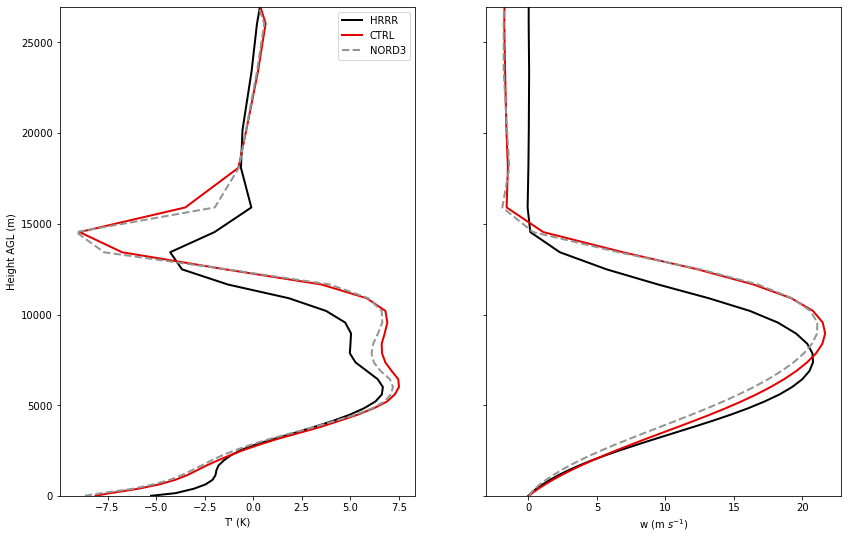

In [10]:
vars_4d_mean = np.nanmean(vars_meso_4d,axis=(1,6)) #now run type, var,time, thresh, height
vars_4d_mean_plot = np.nanmean(vars_4d_mean[:,:,1:,:,:],axis=2)
linecolors=("black","xkcd:red","xkcd:grey")
linestyles=("-","-","--")
linewidths=(2,2,2)
th = 2
print(np.shape(vars_4d_mean_plot))


fig,ax = plt.subplots(1,2,sharey='row')
fig.set_size_inches(14,9)
#fig.subplots = plt.subplots_adjust(hspace=0.4, wspace=0.4)
#fig.suptitle(title, fontsize=24)

for i in np.arange(ng):
    print(i)
    ax[0].plot(vars_4d_mean_plot[i,1,th,:],z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names[i]))

#ax[0].set_xlim((-25.0,0.0))
ax[0].set_ylim((0,np.max(z_interp)))
ax[0].set_ylabel('Height AGL (m)')
#ax[0,0].set_xticks(np.arange(0,60,step=12))
ax[0].set_xlabel('T\' (K)')
ax[0].legend()

for i in np.arange(0,ng):
    ax[1].plot(vars_4d_mean_plot[i,0,th,:],z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i])

# ax[1].set_xlim((0.0,20.0))
ax[1].set_ylim((0,np.max(z_interp)))
#ax[0,0].set_xticks(np.arange(0,60,step=12))
ax[1].set_xlabel('w (m $s^{-1}$)')



<ipython-input-9-cabdfeb75145>:8: RuntimeWarning: Mean of empty slice
  avg_obj_size = np.nanmean(obj_sizes,axis=(1,4))*9.0


Text(0, 0.5, 'Mean uh ($m^2$ $s^{-2}$)')

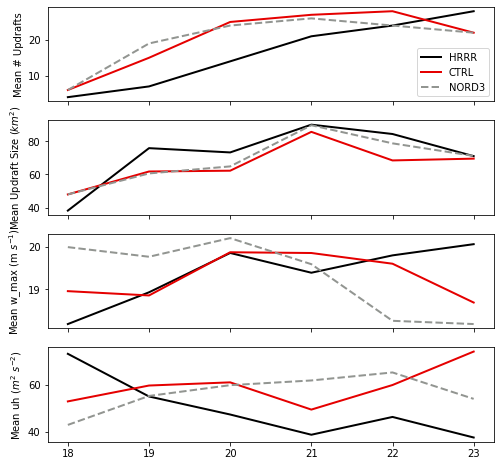

In [9]:
#obj_sizes[g,e,f,th,#]
#ng,ne,n_meso_4dvars,nf,nth,1000
linecolors=("black","xkcd:red","xkcd:grey")
linestyles=("-","-","--")
linewidths=(2,2,2)
th = 0
times = np.arange(18,24)
avg_obj_size = np.nanmean(obj_sizes,axis=(1,4))*9.0
counts = np.nanmean(np.count_nonzero(~np.isnan(obj_sizes), axis=4),axis=1)
vars_3d_mean = np.nanmean(vars_meso_3d,axis=(1,5))

counts_plot = counts[:,:,th]
avg_obj_size_plot = avg_obj_size[:,:,th]
vars_3d_mean_plot = vars_3d_mean[:,:,:,th]
fig,ax = plt.subplots(4,sharex='col')
fig.set_size_inches(8,8)
lines = []
#lines1 = ax[0].plot(time,counts[0,:],label=group_names[0],color=)
#lines = list(lines1)
for i in np.arange(ng):
    lines.append(ax[0].plot(times,counts_plot[i,:],label=group_names[i],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

#ax[0].set_xlim((0,48))
#ax[0].set_ylim((0,25))
ax[0].set_ylabel('Mean # Updrafts')
#ax[0].set_xticks(np.arange(0,60,step=12))
ax[0].legend()

for i in np.arange(ng):
    lines.append(ax[1].plot(times,avg_obj_size_plot[i,:],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

#ax[1].set_xlim((0,48))
#ax[1].set_ylim((0,140.0))
ax[1].set_ylabel('Mean Updraft Size ($km^{2}$)')
#ax[1].set_xticks(np.arange(0,60,step=12))

for i in np.arange(ng):
    lines.append(ax[2].plot(times,vars_3d_mean_plot[i,0,:],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

ax[2].set_ylabel('Mean %s (%s)'%(meso_3dvars_names[0],meso_3dvars_units[0]))

for i in np.arange(ng):
    lines.append(ax[3].plot(times,vars_3d_mean_plot[i,1,:],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i]))

ax[3].set_ylabel('Mean %s (%s)'%(meso_3dvars_names[1],meso_3dvars_units[1]))

In [73]:
print(fs)

['/work/larissa.reames/2019071918/hrrr/region_201907191800_F04.nc', '/work/larissa.reames/2019071918/hrrr/region_201907191800_F05.nc', '/work/larissa.reames/2019071918/hrrr/region_201907191800_F06.nc', '/work/larissa.reames/2019071918/hrrr/region_201907191800_F07.nc', '/work/larissa.reames/2019071918/hrrr/region_201907191800_F08.nc', '/work/larissa.reames/2019071918/hrrr/region_201907191800_F09.nc']


[6. 3. 8. 5. 3. 4. 7. 4.]
(1, 1, 2, 3, 100, 300, 2)
6
3
8
5
3
4
7
4


/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


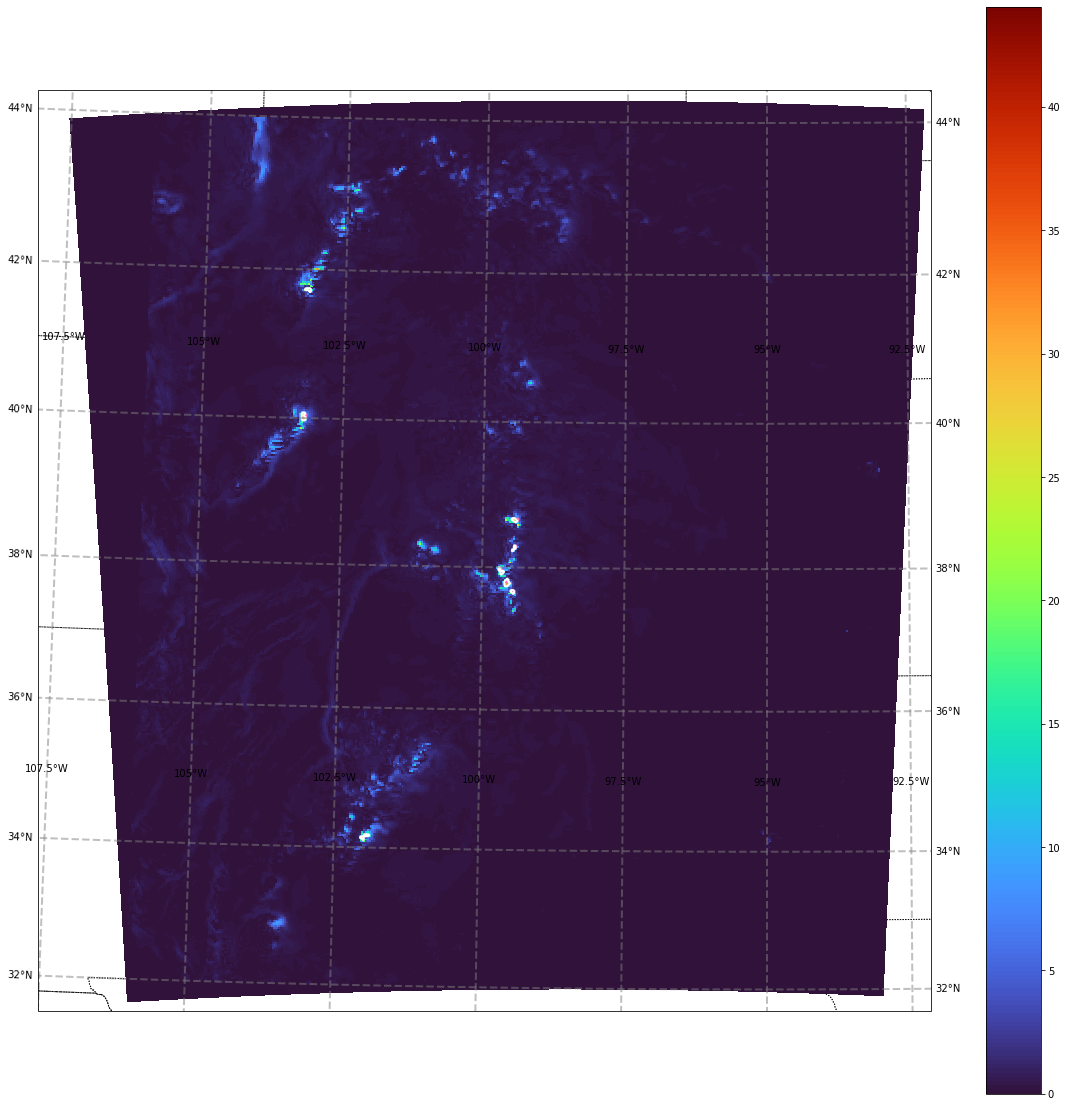

In [23]:
##################################################################
########## Object center locations as a function of time #########
##################################################################
lats = f.lats
lons = f.lons
lon_min = np.amin(lons)
lon_max = np.amax(lons)
lat_min = np.amin(lats)
lat_max = np.amax(lats)
#ng,ne,nf,nth,1000
group = 0
ens = 0
th = 0

proj = ccrs.LambertConformal(central_latitude = 30, 
                             central_longitude = 265., 
                             standard_parallels = (10,10))
        
fig = plt.figure(figsize=(20, 20))

ax = plt.axes(projection = proj)

ax.set_global()
ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
#title = title_string(os.path.basename(file), klevel, 'W', cube[klevel].max(), cube[klevel].min())
    
#w_data = w_sign*np.ma.array(cube[klevel])

#wfinal = np.ma.masked_greater(np.ma.masked_less(w_data, w_limits[0]), w_limits[1])

#for t in np.arange(nf):
t = 0

#Prepare centers
nobjs = np.count_nonzero(~np.isnan(centers[group,ens,t,th,:,0]))
centers_new = np.where(np.isnan(centers),-9999.9,centers)
obj_sizes_new = np.where(np.isnan(obj_sizes),-9999.9,obj_sizes)
print(np.ma.masked_equal(obj_sizes_new[group,ens,t,th,:],-9999.9).compressed())
lat_plot = []
lon_plot = []
for n in np.arange(nobjs):
    x = np.ma.masked_equal(centers_new[group,ens,t,th,:,0],-9999.9).compressed().astype(int)[n]
    y = np.ma.masked_equal(centers_new[group,ens,t,th,:,1],-9999.9).compressed().astype(int)[n]
    lat_plot.append(lats[x,y])
    lon_plot.append(lons[x,y])
#xlocs = centers[group,ens,t,th,np.argwhere(~np.isnan(centers[group,ens,t,th,:,0])),0].transpose().squeeze().astype(int)
#ylocs = centers[group,ens,t,th,np.argwhere(~np.isnan(centers[group,ens,t,th,:,1])),1].transpose().squeeze().astype(int)
#print(np.shape(xlocs))

#Prepare obj outlines
print(np.shape(obj_locs))
nobj = np.count_nonzero(~np.isnan(obj_locs[group,ens,t,th,:,0,0]))
obj_points = np.full(np.shape(vars3d[0,t,:]),0.0)
for l in np.arange(nobj):
    size = np.count_nonzero(~np.isnan(obj_locs[group,ens,t,th,l,:,0]))
    print(size)
    for s in np.arange(size):
        x = obj_locs[group,ens,t,th,l,s,0].astype(int)
        y = obj_locs[group,ens,t,th,l,s,1].astype(int)
        obj_points[x,y] = 1.0
        
pc = ax.pcolormesh(lons, lats, vars3d[0,t,:], cmap='turbo', transform=ccrs.PlateCarree())
ax.scatter(lon_plot,lat_plot,color='hotpink',s=10,transform=ccrs.PlateCarree())
ax.contour(lons,lats,obj_points,levels=['0.5'],colors=['white'],linewidths=[2.0],transform=ccrs.PlateCarree())
fig.colorbar(pc)
#ax.set_title(title,fontsize=20)

plt.show()

fig.savefig('/work/larissa.reames/2021052612/NAM_F12_OBJ.png',dpi=300)